In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from scipy import signal

root = os.path.dirname(os.path.abspath(os.curdir))
sys.path.append(root)

from sr_model.models.models import AnalyticSR
from datasets import inputs
import seaborn as sns
import pandas as pd

/Users/chingfang/Code/sr-project/datasets/inputs.py:12: UserWarning: Emily's experimental data could not be loaded.
  warnings.warn("Emily's experimental data could not be loaded.")


In [2]:
visit_length = 5*3
gamma = 0.99
std = 0.5

In [3]:
factor = 15
cache_states = list(range(7,16))
cache_states = [c*factor for c in cache_states]

while True:
    dataset = inputs.Sim1DFeederAndCache(
        steps_in_phases=[0,15000,0],
        left_right_stay_prob=[2,1,1], expansion=1,
        num_spatial_states=16*factor,
        visit_length=visit_length,
        feeder_states=[], cache_states=cache_states,
        cache_prob = 0.05
        )
    if np.all([c+dataset.num_spatial_states in dataset.state_inputs for c in cache_states]):
        break        

# Sanity Check Plots

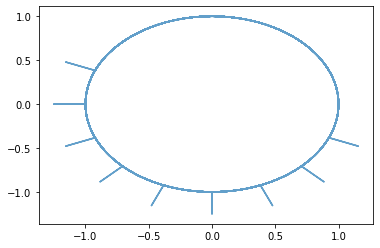

In [4]:
plt.figure();
plt.plot(dataset.xs, dataset.ys, alpha=0.7)
plt.show()

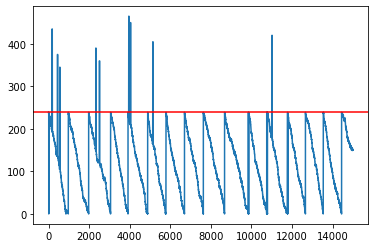

In [5]:
plt.figure();
plt.plot(dataset.state_inputs)
plt.axhline(dataset.num_spatial_states, color='red')
plt.show()

# Run through model

In [6]:
def get_M(T, gamma):
    return np.linalg.pinv(np.eye(T.shape[0]) - gamma*T)
    
def normalize(T):
    row_sums = np.sum(T, axis=1)
    unvisited_states = (row_sums == 0)
    T = T/row_sums[:, np.newaxis]
    T[unvisited_states] = 0
    return T

In [18]:
Ts = []
T_counts = np.zeros((dataset.num_expanded_states, dataset.num_expanded_states))
for step in np.arange(1, dataset.num_steps):
    prev_state = dataset.expanded_state_inputs[step-1]
    curr_state = dataset.expanded_state_inputs[step]
    T_counts[prev_state, curr_state] +=1
    Ts.append(T_counts.copy())

# Plot by dist

In [19]:
from scipy.stats import pearsonr

In [20]:
cache_locs = np.array(dataset.cache_states)
cache_states = np.array(dataset.cache_states) + dataset.num_spatial_states

In [39]:
def get_similarities(indices, state_inputs, time_win=3):
    similarities = []
    _Ts = Ts[time_win:]
    _state_inputs = state_inputs[time_win:]
    for dist in range(len(dataset.cache_states)):
        state1 = indices[0]
        state2 = indices[dist]
        idx1 = np.random.choice(np.argwhere(_state_inputs==state1).flatten())
        idx2 = np.random.choice(np.argwhere(_state_inputs==state2).flatten())
        arr1 = []
        arr2 = []
        for w in np.arange(-time_win, time_win+1):
            M1 = get_M(normalize(_Ts[idx1+w]), gamma)
            arr1.append(M1[state1].copy())
            M2 = get_M(normalize(_Ts[idx2+w]), gamma)
            arr2.append(M2[state2].copy())
        arr1 = np.mean(arr1, axis=0)
        arr2 = np.mean(arr2, axis=0)
        
        arr1 += np.random.poisson(arr1.max()/4., size=arr1.size)
        arr2 += np.random.poisson(arr2.max()/4., size=arr2.size)
        cc = pearsonr(arr1, arr2)[0]
        similarities.append(cc)
    return similarities

iters = 2
similarities = []
dists = []
events = []
for _ in range(iters):
    sim = get_similarities(cache_locs, dataset.state_inputs[1:])
    similarities.extend(sim)
    dists.extend(list(range(len(sim))))
    events.extend(['Spatial']*len(sim))
    similarities.extend(sim[1:])
    dists.extend(list(range(-1, -len(sim), -1)))
    events.extend(['Spatial'] * (len(sim)-1))
    
for _ in range(iters):
    sim = get_similarities(cache_states, dataset.state_inputs[1:])
    similarities.extend(sim)
    dists.extend(list(range(len(sim))))
    events.extend(['Cache']*len(sim))
    similarities.extend(sim[1:])
    dists.extend(list(range(-1, -len(sim), -1)))
    events.extend(['Cache'] * (len(sim)-1))

/var/folders/jf/2_wn4hjd11q9klftv_v_hld80000gn/T/ipykernel_14426/628107314.py:7: RuntimeWarning: invalid value encountered in true_divide
  T = T/row_sums[:, np.newaxis]


In [40]:
df = pd.DataFrame({
    'Similarity': similarities, 'Distance': dists,
    'Event': events
    })

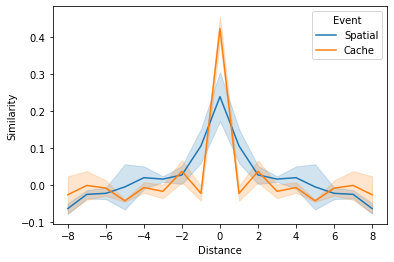

In [41]:
plt.figure()
sns.lineplot(x='Distance', y='Similarity', hue='Event', data=df)
plt.savefig('Similarity.png', dpi=300)
plt.show()